In this Notebook we are going to explore how to finetune the GPT2 and create a Python Question answering mdoel like chatgpt. 
First we tokenize our model and preprocess our text to be formatted the way we want. then we feed it to the model and save the model. next we try using RL model to improve it and finally create a pipeline which is able to give you python code. 
Technologies that has been used:
1. Stackoverflow dataset
2. PyTorch
3. GPT2 Tokenizer, LMHeadModel
4. BERTScore
5. Pipeline()
6. PPOTrainer</p>


You can download the raw data from here: [here](https://www.kaggle.com/datasets/stackoverflow/pythonquestions) 
I've included a small portion of the processed dataset in the files. So you won't need to run Preprocessing NoteBook. But if you want to use the whole dataset, you should download it and then use preprocessing and remove the limitation line. then the output is ready to rerun this model and get good results.
P.S: You need to run all the code since running this code generates a model which is 1.0 GB and I couldnt upload because of the limitation in size.

In [1]:
import os
import time
import json
import nltk
import torch
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ssl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
df=pd.read_csv('data.csv')
df.head(5)

,answer,question,context
0,For reference—future Python possibilities:\nSt...,How do you express binary literals in Python?,How do you express an integer as a binary numb...
1,This will do what you want:\n\nsignum = status...,How do I treat an integer as an array of bytes...,I'm trying to decode the result of the Python ...
2,"\n what is a ""Unicode string"" in Python? Does...",Unicode vs UTF-8 confusion in Python / Django?,I stumbled over this passage in the Django tut...
3,Use the python multiprocessing module which wi...,What's the best way to duplicate fork() in win...,How do I implement some logic that will allow ...
4,I think Cog does what you want.\n,Python code generator for Visual Studio?,"I had an idea, if I add a python .py file to m..."


In [3]:
# drop NA's
df = df.dropna()
df.head()

,answer,question,context
0,For reference—future Python possibilities:\nSt...,How do you express binary literals in Python?,How do you express an integer as a binary numb...
1,This will do what you want:\n\nsignum = status...,How do I treat an integer as an array of bytes...,I'm trying to decode the result of the Python ...
2,"\n what is a ""Unicode string"" in Python? Does...",Unicode vs UTF-8 confusion in Python / Django?,I stumbled over this passage in the Django tut...
3,Use the python multiprocessing module which wi...,What's the best way to duplicate fork() in win...,How do I implement some logic that will allow ...
4,I think Cog does what you want.\n,Python code generator for Visual Studio?,"I had an idea, if I add a python .py file to m..."


In [4]:
# Add marks for original promp and repsonse marks
df['question'] = '[WP]' + df['question'] # + '?'
df['answer'] = '\n[RESPONSE]' + df['answer']
df.head()

,answer,question,context
0,\n[RESPONSE]For reference—future Python possib...,[WP]How do you express binary literals in Python?,How do you express an integer as a binary numb...
1,\n[RESPONSE]This will do what you want:\n\nsig...,[WP]How do I treat an integer as an array of b...,I'm trying to decode the result of the Python ...
2,"\n[RESPONSE]\n what is a ""Unicode string"" in ...",[WP]Unicode vs UTF-8 confusion in Python / Dja...,I stumbled over this passage in the Django tut...
3,\n[RESPONSE]Use the python multiprocessing mod...,[WP]What's the best way to duplicate fork() in...,How do I implement some logic that will allow ...
4,\n[RESPONSE]I think Cog does what you want.\n,[WP]Python code generator for Visual Studio?,"I had an idea, if I add a python .py file to m..."


In [5]:
# merge just question and answer into one
howtos = df["question"] + df["answer"] 
howtos.head()

0    [WP]How do you express binary literals in Pyth...
1    [WP]How do I treat an integer as an array of b...
2    [WP]Unicode vs UTF-8 confusion in Python / Dja...
3    [WP]What's the best way to duplicate fork() in...
4    [WP]Python code generator for Visual Studio?\n...
dtype: object

In [6]:
# clean up by removing certain characters or patterns that may cause issues downstream
howtos.str.replace('"', '').str.replace('\n,\n', '').str.replace('``', '').str.replace(',,', ',')

0       [WP]How do you express binary literals in Pyth...
1       [WP]How do I treat an integer as an array of b...
2       [WP]Unicode vs UTF-8 confusion in Python / Dja...
3       [WP]What's the best way to duplicate fork() in...
4       [WP]Python code generator for Visual Studio?\n...
                              ...                        
5454    [WP]How can i solve this regular expression, P...
5455    [WP]is_max = s == s.max() | How should I read ...
5456    [WP]How two recursion function in program work...
5457    [WP]Pandas: How to conditionally assign multip...
5458    [WP]How to use a dict to subset a DataFrame?\n...
Length: 5459, dtype: object

/home/ssl/miniconda3/envs/cuda_tf2/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  del sys.path[0]


<AxesSubplot:ylabel='Density'>

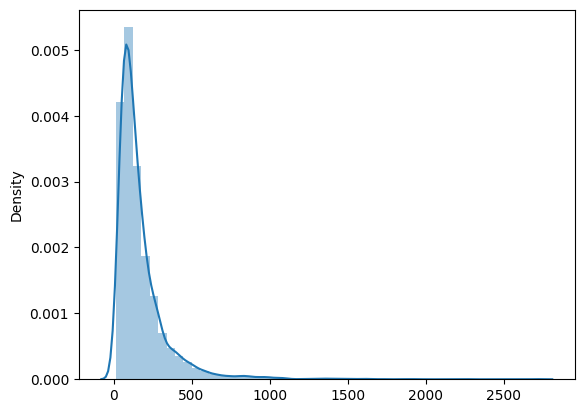

In [7]:
# check distribution of the answers' length
doc_lengths = []

for howto in howtos:

    # get rough token count distribution
    tokens = nltk.word_tokenize(howto)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [8]:
# The distribution of answers with the length of more than 128
len(doc_lengths[doc_lengths > 128])/len(doc_lengths)

0.4680344385418575

In [9]:
np.average(doc_lengths)

172.86334493496977

In [10]:
# Load the GPT tokenizer and add special tokens.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [11]:
batch_size = 4

Defining a PyTorch dataset class called GPT2Dataset that prepares text data for use with a GPT-2 language model

In [12]:
class GPT2Dataset(Dataset):
    # Define the class constructor method
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=512):
        
        # Store the tokenizer and initialize the input_ids and attn_masks lists
        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []
        
        # Iterate through each text sample in txt_list
        for txt in txt_list:
            
            # Tokenize the text sample using the tokenizer and truncate it if necessary
            text = txt
            encodings_dict = tokenizer('<|startoftext|>'+ text + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")
            
            # Add the tokenized input and attention mask to their respective lists
            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            
    # Define the __len__ method, which returns the number of input samples in the dataset
    def __len__(self):
        return len(self.input_ids)
    
    # Define the __getitem__ method, which returns the input sample and corresponding attention mask at a given index
    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [13]:
dataset = GPT2Dataset(howtos, tokenizer, max_length=512)

# Split the dataset into training and validation sets with a 80/20 split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

4,367 training samples
1,092 validation samples


In [14]:
# Create a PyTorch DataLoader instance for the training set 
train_dataloader = DataLoader(
            train_dataset,  # The training dataset
            sampler = RandomSampler(train_dataset), # Randomly sample elements from the training dataset
            batch_size = batch_size # The number of samples per batch to load
        )

# Create a PyTorch DataLoader instance for the validation set
validation_dataloader = DataLoader(
            val_dataset, # The validation dataset
            sampler = SequentialSampler(val_dataset), # Iterate through the validation dataset sequentially
            batch_size = batch_size # The number of samples per batch to load
        )

In [15]:
# Load the GPT2Config from the 'gpt2' pre-trained model and set output_hidden_states to False
configuration = GPT2Config.from_pretrained('gpt2', 
                                           output_hidden_states=False)
# Instantiate the GPT2LMHeadModel with the 'gpt2' pre-trained weights and the configuration we just loaded
model = GPT2LMHeadModel.from_pretrained("gpt2", 
                                        config=configuration)

# Resize the model's token embeddings to match the size of the tokenizer's vocabulary
# This step is necessary if any special tokens have been added to the tokenizer
model.resize_token_embeddings(len(tokenizer))

Embedding(50259, 768)

In [16]:
# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

# Set the random seed for the Python built-in `random` module.
random.seed(seed_val)
np.random.seed(seed_val)

# Set the random seed for PyTorch to ensure reproducibility on the GPU.
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [17]:
epochs = 2
learning_rate = 3e-4
warmup_steps = 1e2
epsilon = 1e-5
check_path = './checkpoints'
sample_every = 100

In [18]:
import torch.optim as optim

# Define the optimizer to use.
# We're using the AdamW optimizer with the given learning rate, epsilon, and weight decay.
# We're passing the model's parameters to the optimizer so that it can update them during training.
optimizer = optim.AdamW(model.parameters(),
                        lr=learning_rate,
                        eps=epsilon,
                       weight_decay = 0.01)

In [19]:
# Calculate the total number of training steps.
# This is the number of batches in the training data multiplied by the number of epochs.
total_steps = len(train_dataloader) * epochs

# Set up the learning rate scheduler.
# We're using the linear scheduler with warmup, which increases the learning rate
# linearly from 0 to the initial learning rate over the first few training steps
# (the warmup steps), and then decreases the learning rate linearly to zero over
# the remaining training steps.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [20]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [21]:
# Release all unused memory that is held by the GPU memory cache
torch.cuda.empty_cache()

In [22]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Record the start time of the epoch.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()

    # Loop over each batch of training data.
    for step, batch in enumerate(train_dataloader):

        # Get the input IDs, attention masks, and labels for this batch,
        # and move them to the GPU if necessary.
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        # Zero out any gradients that have accumulated from previous batches.
        model.zero_grad()        

        # Run this batch through the model to get the loss.
        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        # Get the loss for this batch, and add it to the total loss for this epoch.
        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Print some generated output every `sample_every` batches.
        if step % sample_every == 0 and not step == 0:
            
            # Measure how long this has taken so far.
            elapsed = format_time(time.time() - t0)

            # Put the model into evaluation mode.
            model.eval()

            # Generate some sample output from the model.
            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 512,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    pad_token_id=tokenizer.eos_token_id,
                                    eos_token_id=-1,
                                )
            # Put the model back into training mode.
            model.train()

        # Backpropagate the loss and update the model parameters.
        loss.backward()
        optimizer.step()

        # Update the learning rate scheduler.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")
    # Perform validation on the model after training for each epoch.
    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...

  Average training loss: 1.52
  Training epoch took: 0:03:45

Running Validation...
  Validation Loss: 1.06
  Validation took: 0:00:14

======== Epoch 2 / 2 ========
Training...


KeyboardInterrupt: 

The increasing validation loss shows that the model is overfitting to the training data. Although the model is getting better at predicting the training data but cannot generalize well to the new data, which is the validation data.
The reason is model is too complex, and it is able to learn the noise in the training data as well, which is not present in the validation data. We need more data for that. Let's see if we can improve it or not?!</p>
(P.S. I have tried this configuration with full dataset and the results were satisfying. Since it was supposed to be small notebook, I shortened the dataset from 600.000 questions to less than 5500 samples.)

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Set the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Retrieve a list of all the named parameters in the model
params = list(model.named_parameters())

# Print the total number of named parameters in the GPT-2 model
print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

# Print the size of the parameters in the embedding layer
print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Print the size of the parameters in the first transformer block
print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Print the size of the parameters in the output layer
print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [ ]:
# Sets the directory to which the trained model will be saved
output_dir = './models'

# If the directory does not exist, it is created
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#Prints the directory where the model will be saved
print("Saving model to %s" % output_dir)

# This line ensures that the correct model is saved even if the code is running in a distributed/parallel environment
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# Saves the trained model to the specified directory
model_to_save.save_pretrained(output_dir)

In [ ]:
export_path = './models'
torch.save(model, f'{export_path}/gpt2_v2.pt')
tokenizer.save_pretrained(export_path)

In [ ]:
# This cell is just written for those who wants to adjust the number of responses and see the result for just one question 
model.eval()
input_prompt = "How to draw a circle"

prompt = f"\n<|startoftext|>[WP] {input_prompt} \n[RESPONSE]"

# The input prompt is tokenized and converted to a tensor, which is then sent to the GPU.
generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

# Generates 3 responses to a given input prompt using a pre-trained language model.
sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 512,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

In [ ]:
test_df = pd.read_csv('data_test.csv')
test_df.head(5)

In [ ]:
# Generates the answer for the data test.
model.eval()
def generate_ans(question: str):
    responses = []
    input_prompt = question
    prompt = f"\n<|startoftext|>[WP] {input_prompt} \n[RESPONSE]"

    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    sample_outputs = model.generate(
                                    generated, 
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 512,
                                    top_p=0.95, 
                                    num_return_sequences=2
                                    )
    for i, sample_output in enumerate(sample_outputs):
        response_text = tokenizer.decode(sample_output, skip_special_tokens=True)
        wp_responses = re.split(r"\[WP\].*?\n|\[RESPONSE\]", response_text)[1:]
        new_list = [elem for elem in wp_responses if elem != '']
        responses.append(new_list[0])
    return responses

In [ ]:
# Creates two arrays and store the first answer to answers1 and second answer for each question to answers2
import re
from tqdm import tqdm
answers1 = []
answers2 = []
for _, row in tqdm(test_df.iterrows()):
    _, question, _ = row
    answer_gpt = generate_ans(question)
    answers1.append(answer_gpt[0])
    answers2.append(answer_gpt[1])


BERTScore metric for evaluating the quality of generated text.It takes two lists of strings, `cands` and `refs`, where cands contains the generated text and refs contains the reference or ground-truth text. It returns three tensors: P, R, and F1, where P is precision, R is recall, and F1 is the harmonic mean of precision and recall. Each tensor has the same shape as the input cands and refs.

In [ ]:
# Evaluate the generated answers
import bert_score
from evaluate import load
bertscore = load('bertscore')

bertscore_gpt2 = bertscore.compute(predictions=answers1, 
                                           references=test_df['answer'].to_list(), 
                                           lang='en')['f1']
bertscore_gpt_2 = bertscore.compute(predictions=answers2, 
                                           references=test_df['answer'].to_list(), 
                                           lang='en')['f1']

In [ ]:
bertscore_gpt2

In [ ]:
# Save the generated answers and their scores   
test_df['first_gpt2_answer'] = answers1
test_df['second_gpt2_answer'] = answers2

test_df['bert_score_first_gpt2'] = bertscore_gpt2
test_df['bert_score_second_gpt2'] = bertscore_gpt_2

In [ ]:
test_df.head(5)

In [ ]:
np.mean(test_df['bert_score_first_gpt2'])

In [ ]:
np.mean(test_df['bert_score_second_gpt2'])

In [ ]:
test_df.to_csv('./data/eval_results.csv', index=False)

In [ ]:
results_df = pd.read_csv('./data/eval_results.csv')
results_df.head(20)

In [ ]:
# creates a dataset dictionary containing training examples and labels for a binary classification task. 
# The goal of the classification task is to predict which of two generated responses is 
# better in terms of BERTScore.
dataset = {}
for _, row in results_df.iterrows():
    _, _,_, answers1, answers2, bertscore_gpt2, bertscore_gpt2_2 = row
    if bertscore_gpt2 > bertscore_gpt2_2:
        dataset[answers1] = 1
        dataset[answers2] = 0
    elif bertscore_gpt2 < bertscore_gpt2_2:
        dataset[answers1] = 0
        dataset[answers2] = 1
    else:
        len_1 = len(answers1)
        len_2 = len(answers2)
        if len_1 < len_2:
            dataset[answers1] = 1
            dataset[answers2] = 0
        elif len_1 > len_2:
            dataset[answers1] = 0
            dataset[answers2] = 1
        else:
            dataset[answers1] = 1
            dataset[answers2] = 0

In [ ]:
clf_dataset = pd.DataFrame(list(dataset.items()), columns=['response', 'label'])
clf_dataset.head()

In [ ]:
clf_dataset.count()

In [ ]:
clf_dataset = clf_dataset.sample(frac=1).reset_index(drop=True)
clf_dataset.to_csv('./data/clf_dataset.csv', index=False)

In [ ]:
from transformers import BertForSequenceClassification
from transformers import TrainingArguments
from transformers import BertTokenizerFast
from datasets import load_dataset
from transformers import pipeline
from transformers import set_seed
from transformers import Trainer
from datasets import DatasetDict
import transformers
import numpy as np
import datasets
import logging 
import torch
import os

In [ ]:
N_GPUS = 1
TRAIN_EPOCHS = 2
TRAIN_BATCH_SIZE = 8
EVAL_BATCH_SIZE = 8
MAX_LEN = 128
LOGGING_STEPS = 64
SAVE_STEPS = 10240  # reduce it to a smaler value like 512 if you want to save checkpoints
SAVE_TOTAL_LIMIT = 2

set_seed(123)

In [ ]:
# creates an instance of the BertForSequenceClassification class from the Hugging Face Transformers library.
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2,  force_download=True)

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
data = load_dataset('csv', 
                     data_files='./data/clf_dataset.csv', 
                     delimiter=',', 
                     split='train', 
                     cache_dir='/tmp/cache')

In [ ]:
train_validation_test = data.train_test_split(shuffle=True, seed=123, test_size=0.1)
data_splits = DatasetDict({'train': train_validation_test['train'],  
                           'validation': train_validation_test['test']})

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['response'], truncation=True, padding=True)

In [ ]:
# Tokenize datasets 
num_proc = int(os.cpu_count()/N_GPUS)
tokenized_data = data_splits.map(preprocess_function, batched=True, num_proc=num_proc)

# Finetune
Define training hyperparameters

In [ ]:
# Set various training parameters such as the number of training epochs, batch size, and logging options.
training_args = TrainingArguments(output_dir='./model', 
                                  overwrite_output_dir=True, 
                                  num_train_epochs=10,  
                                  optim='adamw_torch', 
                                  save_strategy='steps', 
                                  evaluation_strategy='epoch',
                                  per_device_train_batch_size=TRAIN_BATCH_SIZE, 
                                  per_device_eval_batch_size=EVAL_BATCH_SIZE, 
                                  warmup_steps=10, 
                                  weight_decay=0.01,
                                  logging_steps=LOGGING_STEPS,
                                  save_steps=SAVE_STEPS, 
                                  save_total_limit=SAVE_TOTAL_LIMIT,
                                  logging_dir='logs')

### Training
P.S: Since our dataset is small it has overfits

In [ ]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  train_dataset=tokenized_data['train'], 
                  eval_dataset=tokenized_data['validation'], 
                  tokenizer=tokenizer)

trainer.train()

In [ ]:
from trl import AutoModelForCausalLMWithValueHead
from transformers import GPT2Tokenizer
from transformers import set_seed
from datasets import load_dataset
from transformers import pipeline
from datasets import Dataset
from random import choices
from trl import PPOTrainer
from trl import PPOConfig
from evaluate import load
from tqdm import tqdm
import transformers 
import pandas as pd
import numpy as np
import bert_score
import ipywidgets
import datasets
import evaluate
import logging
import jupyter
import random
import torch
import wandb
import time
import trl
import os

In [ ]:
pd.options.display.max_colwidth = None
np.random.seed(123)
tqdm.pandas()
set_seed(123)

In [ ]:
!wandb login ee62107bfb3cfc4fb4a7087e8b9761437363721d

### PPO
Defining a configuration object for the Proximal Policy Optimization (PPO) algorithm

In [ ]:
config = PPOConfig(model_name='./model/finetuned', 
                   batch_size=4,
                   learning_rate=1.41e-6,
                   forward_batch_size=4, # This parameter is useful when using large models that don't fit into memory.
                   remove_unused_columns=False, # All columns in the input data will be used during training.
                   log_with='wandb'# For logging training metrics
                  )

In [ ]:
# Provides an interface for using pre-trained models for language modeling. 
# This class can generate sequences of text based on a given prompt.
# two pre-trained language models, loaded from the specified directories, 
# which will be used as the "actor" and "critic" in the PPO algorithm.
# Note: for further improvement, we can use answer1 and create model and answer2 
# and create another model and use them as actor critic. since the data is not big enough it is not a good idea
active_model = AutoModelForCausalLMWithValueHead.from_pretrained('./models')
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained('./models')

In [ ]:
dataset = load_dataset('csv', 
                       data_files='./data_test.csv',  
                       delimiter=',', 
                       split='train[:100%]',
                       download_mode='force_redownload')
dataset

In [ ]:
def tokenize(samples: list):
    questions = samples['question']
    ground_truth = samples['answer']
    
    input_ids = []
    query = []
    
    for question in questions:
        prompted_input = f'question: {question}\nanswer:'
        query.append(prompted_input)
        tokenized_input = tokenizer(prompted_input, 
                                    truncation=True)
        input_ids.append(torch.tensor(tokenized_input['input_ids'], dtype=torch.long))
        
    return {'input_ids': input_ids, 'query': query, 'ground_truth': ground_truth, 'questions': questions}

In [ ]:
dataset = dataset.map(tokenize, 
                      batched=True, 
                      #num_proc=num_proc, 
                      load_from_cache_file=False, 
                      remove_columns=['question', 'answer'])
dataset.set_format('pt', 
                   columns=['input_ids', 'query', 'ground_truth'],
                   output_all_columns=True)
dataset

In [ ]:
def collator(dataset):
    result = {}
    for key in dataset[0]:
        values = []
        for d in dataset:
            values.append(d[key])
        result[key] = values
    return result

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# creates an instance of the PPOTrainer class
ppo_trainer = PPOTrainer(config, active_model, ref_model, tokenizer, dataset=dataset, data_collator=collator)

pipeline: a high-level API provided by the transformers library, which makes it easy to use pre-trained models for a variety of natural language processing tasks, including text generation.

In [ ]:
bert_pipe = pipeline('text-generation', 
                     model='./models',
                    max_length = MAX_LEN)

In [ ]:
import json
prompt = "How can I sum two integers in python?"
output = bert_pipe(prompt, max_length=512, num_return_sequences=1)
output = output[0]['generated_text']
response_text = output.split('[RESPONSE]')[1]
formatted_text = "```\n" + response_text + "\n```"
print(formatted_text)

Tadda!! our model can now write quite reasonable python code! Enjoy :-)

You can improve this by Just defining two models and use PPO trainer based on that. this way the model will be able to improve itself by comparing two responses and produce better results. 